# Solar and Wind Curtailment

Renewables like wind and solar regularly produce energy in excess of demand. In order to keep supply and demand balanced on the grid, the result is "curtailment", or purposefully reducing output.

In this notebook, we'll walk through accessing the curtailment data for CAISO

In [1]:
import gridstatus
import pandas as pd
import plotly.express as px
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
iso = gridstatus.CAISO()

## Get Curtailment Data

First, we will query for curtailment data. CAISO publishes curtailment data starting on June 30, 2016. We use the `save_to` parameter to save the data locally, so it is easier to reload later.

In [3]:
df = iso.get_curtailment(
    start="Jan 1, 2020", end="Mar 30, 2023", save_to="curtailment/"
)

100%|██████████| 1184/1184 [52:58<00:00,  2.68s/it] 


we can easily reload the data in the curtailment folder like this. By default it loads with UTC timezone unless we specify otherwise.

In [5]:
df = gridstatus.load_folder("curtailment", time_zone=gridstatus.CAISO.default_timezone)

# use interval start only
df = df.drop(columns=["Time", "Interval End"])

100%|██████████| 1184/1184 [00:00<00:00, 1270.60it/s]


next, let's reformat the data to make it easier to work with


In [20]:
df["Type"] = (
    df["Curtailment Reason"].str.lower().str.capitalize()
    + " "
    + df["Fuel Type"]
    + " Curtailment (MWh)"
)
curtailment = df.pivot_table(
    values="Curtailment (MWh)",
    index="Interval Start",
    columns="Type",
    # sum to account for 'Economic' and 'SelfSchCut' reasons
    aggfunc="sum",
).fillna(0)

curtailment["Total Solar Curtailment (MWh)"] = (
    curtailment["Local Solar Curtailment (MWh)"]
    + curtailment["System Solar Curtailment (MWh)"]
)
curtailment["Total Wind Curtailment (MWh)"] = (
    curtailment["Local Wind Curtailment (MWh)"]
    + curtailment["System Wind Curtailment (MWh)"]
)
curtailment["Total Curtailment (MWh)"] = (
    curtailment["Total Solar Curtailment (MWh)"]
    + curtailment["Total Wind Curtailment (MWh)"]
)
curtailment.columns.name = None
curtailment = curtailment.resample("1H").sum()
curtailment

,Local Solar Curtailment (MWh),Local Wind Curtailment (MWh),System Solar Curtailment (MWh),System Wind Curtailment (MWh),Total Solar Curtailment (MWh),Total Wind Curtailment (MWh),Total Curtailment (MWh)
Interval Start,,,,,,,
2020-01-01 08:00:00-08:00,0.0,0.0,27.0,6.0,27.0,6.0,33.0
2020-01-01 09:00:00-08:00,78.0,7.0,138.0,13.0,216.0,20.0,236.0
2020-01-01 10:00:00-08:00,12.0,0.0,917.0,43.0,929.0,43.0,972.0
2020-01-01 11:00:00-08:00,19.0,0.0,1229.0,44.0,1248.0,44.0,1292.0
2020-01-01 12:00:00-08:00,216.0,25.0,1194.0,131.0,1410.0,156.0,1566.0
...,...,...,...,...,...,...,...
2023-03-29 13:00:00-07:00,204.0,4.0,0.0,0.0,204.0,4.0,208.0
2023-03-29 14:00:00-07:00,133.0,0.0,0.0,0.0,133.0,0.0,133.0
2023-03-29 15:00:00-07:00,85.0,0.0,0.0,7.0,85.0,7.0,92.0


## Visualizing Curtailment

### Cumulative Curtailment by Year

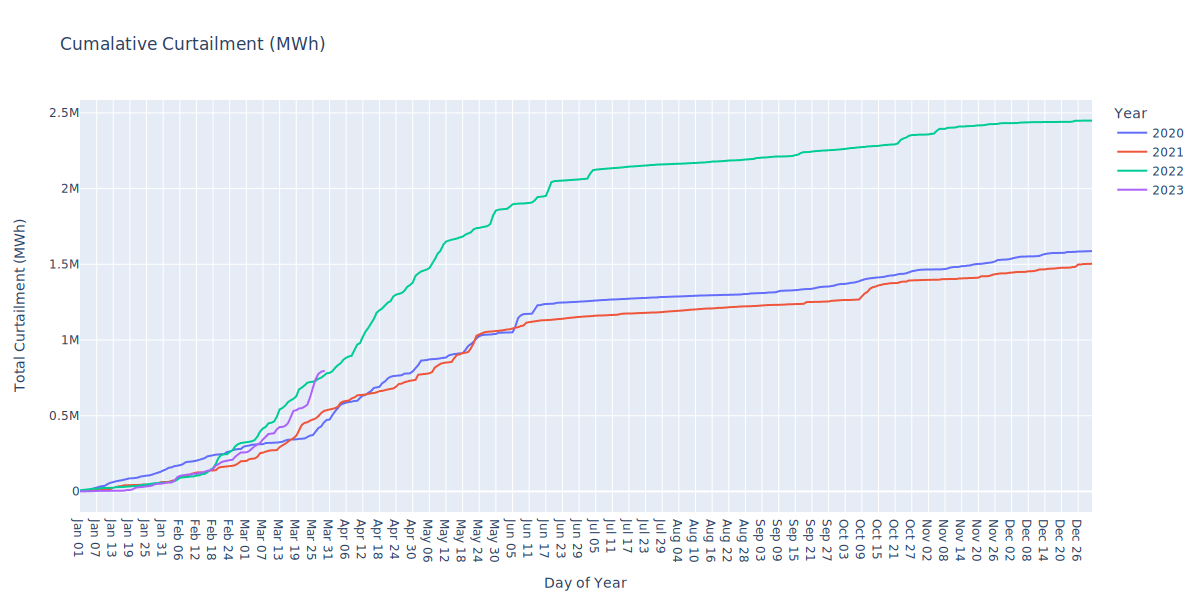

In [43]:
daily_curtailment = curtailment.resample("1D").sum()
cumulative_curtailment = (
    daily_curtailment.groupby(daily_curtailment.index.year)["Total Curtailment (MWh)"]
    .cumsum()
    .reset_index()
)
cumulative_curtailment["Year"] = cumulative_curtailment["Interval Start"].dt.year
cumulative_curtailment["Day of Year"] = cumulative_curtailment[
    "Interval Start"
].dt.strftime("%b %d")

# plot all years together
fig = px.line(
    cumulative_curtailment,
    y="Total Curtailment (MWh)",
    x="Day of Year",
    title="Cumalative Curtailment (MWh)",
    color="Year",
)

fig.show("svg", width=1200, height=600)

### Monthly Curtailment

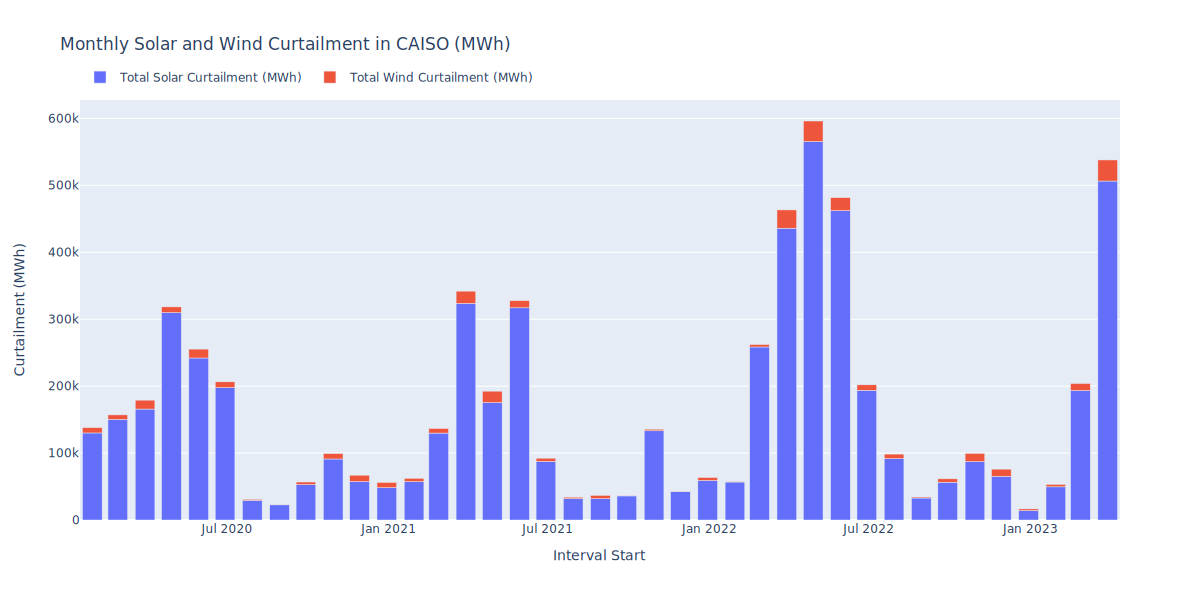

In [41]:
monthly = curtailment.resample("M").sum()
monthly["Month"] = monthly.index.month
monthly["Year"] = monthly.index.year

fig = px.bar(
    monthly,
    x=monthly.index,
    y=["Total Solar Curtailment (MWh)", "Total Wind Curtailment (MWh)"],
    title="Monthly Solar and Wind Curtailment in CAISO (MWh)",
)

# legend upper left corner
fig.update_layout(
    legend=dict(
        orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0, title_text=None
    )
)
fig.update_yaxes(title_text="Curtailment (MWh)")
fig.show("svg", width=1200, height=600)

### Average Hourly Curtailment

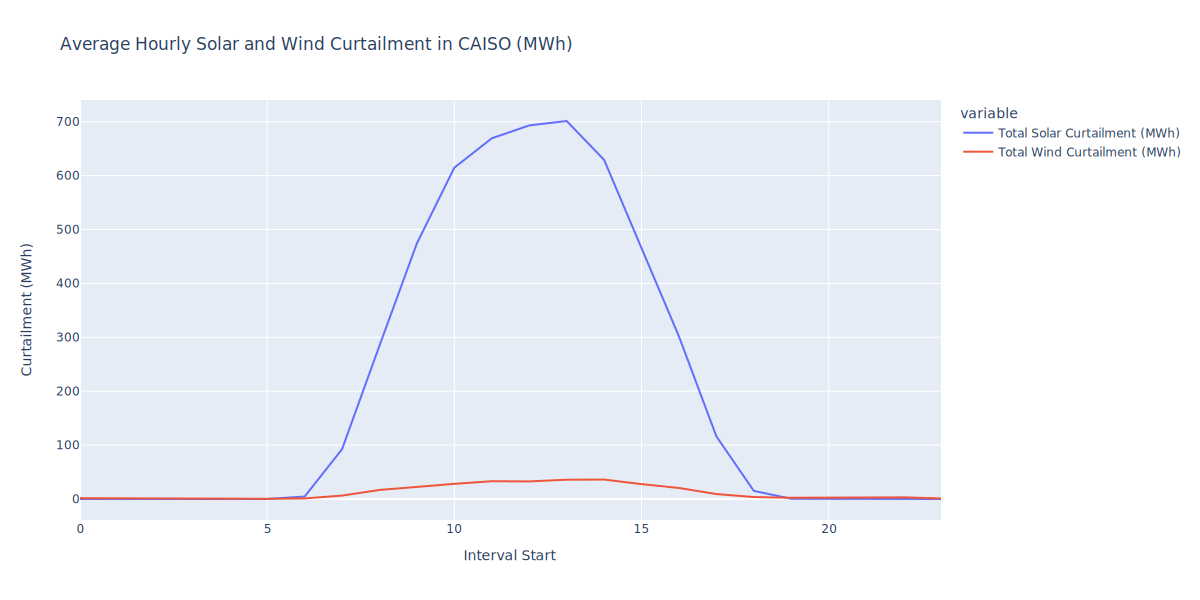

In [42]:
avg_hourly = curtailment.groupby(curtailment.index.hour).mean()
fig = px.line(
    avg_hourly,
    x=avg_hourly.index,
    y=["Total Solar Curtailment (MWh)", "Total Wind Curtailment (MWh)"],
    title="Average Hourly Solar and Wind Curtailment in CAISO (MWh)",
)
fig.update_yaxes(title_text="Curtailment (MWh)")
fig.show("svg", width=1200, height=600)

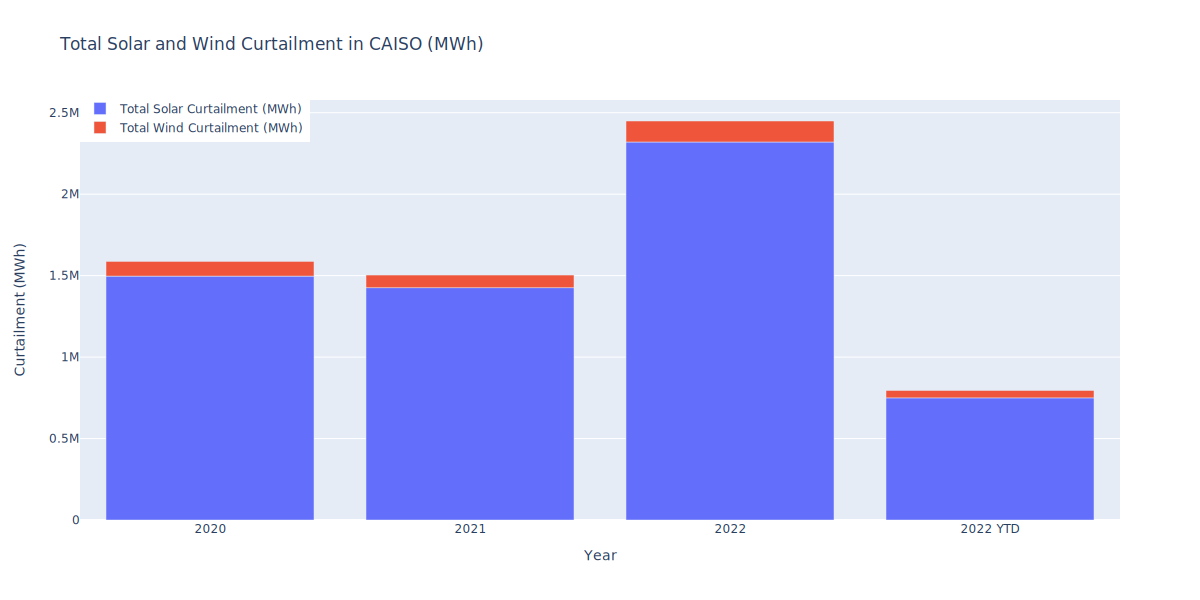

In [9]:
curtailment["Year"] = curtailment.index.year
yearly_sum = curtailment.groupby("Year").sum()
index = yearly_sum.index.astype(str).tolist()
index[-1] = "2022 YTD"
yearly_sum.index = index

fig = px.bar(
    yearly_sum,
    x=yearly_sum.index,
    y=["Total Solar Curtailment (MWh)", "Total Wind Curtailment (MWh)"],
    title="Total Solar and Wind Curtailment in CAISO (MWh)",
)
fig.update_layout(
    legend=dict(yanchor="bottom", y=0.9, xanchor="left", x=0, title_text=None)
)
fig.update_yaxes(title_text="Curtailment (MWh)")
fig.update_xaxes(title_text="Year")
fig.show("svg", width=1200, height=600)